# Applying GNN Methods to Root Cause Analysis of Autonomous Vehicle Systems
Tianyang Chen, Huiwen Han, and Alycia Lee

This notebook contains a GNN modeling pipeline for modeling dynamic systems, and performing Root Cause Analysis (RCA) on scenarios modeled after autonomous vehicle software systems.

This notebook trains and evaluates undirected and directed versions of spatial and spatiotemporal models based on GCN, GraphSage, and GAT. The spatiotemporal models combine GRU with each of these GNN methods.


References:
1. https://github.com/emalgorithm/directed-graph-neural-network/tree/main
2. https://emanuelerossi.co.uk/blog/2023/dirgnn/

# Install dependencies

In [1]:
!pip install pytorch_lightning
!pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn, optim
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.nn import ModuleList, Linear, ReLU, GRU
from torch_geometric.nn import (
    SAGEConv,
    GCNConv,
    GATConv,
    global_mean_pool,
    global_max_pool,
    global_add_pool,
)
from torch_geometric.data import Data, DataLoader, Dataset

import copy
from datetime import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import os.path as osp
import pandas as pd
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import time

# Seed everything
seed = 42
random.seed(seed)
torch.manual_seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = False

In [3]:
USE_WANDB = False

if USE_WANDB:
  import wandb
  os.environ['WANDB_API_KEY']='d8e70c9cb01a88ace48a2ec6d18bd9e9be24c73b'
  os.environ['WANDB_ENTITY']='yundddd-stanford-university'
  os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'
  wandb.login();

In [4]:
# Download the simulated dataset zip file
!wget https://github.com/yundddd/graph_generator/raw/master/graph_generator/dataset/autonomous_vehicle2.zip

# Unzip the file
!unzip autonomous_vehicle2.zip

--2024-12-12 14:26:14--  https://github.com/yundddd/graph_generator/raw/master/graph_generator/dataset/autonomous_vehicle2.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yundddd/graph_generator/master/graph_generator/dataset/autonomous_vehicle2.zip [following]
--2024-12-12 14:26:15--  https://raw.githubusercontent.com/yundddd/graph_generator/master/graph_generator/dataset/autonomous_vehicle2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18679893 (18M) [application/zip]
Saving to: ‘autonomous_vehicle2.zip’

autonomous_vehicle2 100%[===================>]  17.81M  98.6MB/s    in 0.2s    

# Construct SimulatedDataset

In [5]:
FEATURE_DIMENSION = 9
TIMESTAMP_FEATURE_INDEX = 3
HEALTHY_NODE_LABEL = 0
ROOT_CAUSE_NODE_LABEL = 1
NUM_CLASSES = 2
NUM_NODES = 46

class SimulatedDataset():
  """
  Represents a simulated dataset generated using the graph executor.
  Used for training and evaluating graph-based machine learning models.
  """
  def __init__(self, edge_idx_path, node_features_path, fault_label_path):
    """
    Constructs all the necessary attributes for the SimulatedDataset object.

    Parameters
    ----------
    edge_idx_path : str
        Path to the file containing edge indices.
    node_features_path : str
        Path to the file containing node features.
    fault_label_path : str
        Path to the file containing fault labels.
    """
    self.edge_idx_path = edge_idx_path
    self.node_features_path = node_features_path
    self.fault_label_path = fault_label_path

    self.edge_index = self.get_edge_index(self.edge_idx_path)
    self.node_features, self.node_labels, self.time_stamps = self.get_node_features(self.node_features_path, self.fault_label_path)
    self.dataset_stats()


  def get_edge_index(self, path):
    """
    Reads edge indices from a file and returns a tensor in COO format.

    Parameters
    ----------
    path : str
        Path to the file containing edge indices.

    Returns
    -------
    torch.Tensor
        Tensor containing edge indices in COO format.
    """
    edges = []
    with open(path, "r") as output:
      i = 0
      for line in output:
        edge = line.strip().split(',')
        edges.append([int(edge[0]), int(edge[1])])
    return torch.tensor(edges, dtype=torch.long).t().contiguous() # put edges into COO format

  def get_node_at_fault(self, path):
    """
    Reads the node at fault and the timestamp of fault from a file.

    Parameters
    ----------
    path : str
        Path to the file containing fault labels.

    Returns
    -------
    tuple
        Tuple containing the node at fault and the timestamp of fault.
    """
    node_at_fault, timestamp_of_fault = 0, 0
    with open(fault_label_path, "r") as output:
      ind = 0
      for line in output:
        node_at_fault, timestamp_of_fault = line.strip().split(',')
        ind += 1
      assert ind == 1 # there should only be one line in this file
    return int(node_at_fault), int(timestamp_of_fault)

  def get_node_features(self, node_features_path, fault_label_path):
    """
    Reads node features and labels from files and returns them.

    Parameters
    ----------
    node_features_path : str
        Path to the file containing node features.
    fault_label_path : str
        Path to the file containing fault labels.

    Returns
    -------
    tuple
        Tuple containing lists of node features, node labels, and timestamps for each graph.
    """
    node_features, node_labels, time_stamps = [], [], []
    node_at_fault, timestamp_of_fault = self.get_node_at_fault(fault_label_path)
    with open(node_features_path, "r") as output:
      for line in output:
        items = line.strip().split(',')
        features = [list(map(int, items[i + 1 : i + FEATURE_DIMENSION + 1]))
                          for i in range(0, len(items), FEATURE_DIMENSION + 1)]
        time = max([node[TIMESTAMP_FEATURE_INDEX] for node in features])
        features = torch.tensor(features)
        node_features.append(features)
        labels = [HEALTHY_NODE_LABEL] * features.shape[0]
        if time >= timestamp_of_fault:
          labels[node_at_fault] = ROOT_CAUSE_NODE_LABEL
        labels = torch.tensor(labels).reshape(features.shape[0])
        node_labels.append(labels)
        time_stamps.append(time)
    return node_features, node_labels, time_stamps

  def dataset_stats(self):
    """
    Computes and sets various statistics of the dataset.
    """
    self.feature_dimension = self.node_features[0].shape[1]
    self.num_nodes = self.node_features[0].shape[0]
    self.num_edges = self.edge_index.shape[1]
    self.num_graphs = len(self.node_features)
    self.num_classes = 2

  def report_dataset_stats(self):
    """
    Prints the statistics of the dataset.
    """
    print(f'Number of nodes: {self.num_nodes}')
    print(f'Number of edges: {self.num_edges}')
    print(f'Number of graphs: {self.num_graphs}')
    print(f'Number of classes: {self.num_classes}')
    print(f'Feature dimension: {self.feature_dimension}')
    print(f'Node features: {self.node_features}')
    print(f'Node labels: {self.node_labels}')
    print(f'Edge index: {self.edge_index}')

## Helper functions

In [38]:
def get_injection_time(file_name):
  """
  Extracts the injection time from a file name.

  Parameters
  ----------
  file_name : str
      The name of the file containing the injection time information.

  Returns
  -------
  str
      The injection time extracted from the file name.
  """
  return file_name.split('_')[-1].split('.')[0]

def load_timestamp_instance(raw_data_path, subfolder, injection_time):
  """
  Loads a timestamp instance from raw data and constructs a list of graph data.

  Parameters
  ----------
  raw_data_path : dict
      Dictionary containing paths to raw data organized by subfolder and injection time.
  subfolder : str
      The subfolder within the raw data path containing the data.
  injection_time : str
      The specific injection time to load data for.

  Returns
  -------
  list
      A list of Data objects, each representing a graph at a different timestamp.
  """
  print("load_timestamp_instance:", subfolder, injection_time)
  instance = raw_data_path[subfolder][injection_time]
  pyg_dataset = SimulatedDataset(instance['edge_idx_path'], instance['node_features_path'], instance['fault_label_path'])

  data_list = []
  for i in range(pyg_dataset.num_graphs):
      x = pyg_dataset.node_features[i]
      y = pyg_dataset.node_labels[i]
      edge_index = pyg_dataset.edge_index
      timestamp = pyg_dataset.time_stamps[i]

      graph_data = Data(timestamp=timestamp, x=x, y=y, edge_index=edge_index)
      data_list.append(graph_data)

  return data_list

def randomly_sample_instances(num_samples, raw_data_path, subfolder):
  """
  Randomly samples instances from raw data based on injection times.

  Parameters
  ----------
  num_samples : int
      The number of samples to randomly select.
  raw_data_path : str
      Path to the raw data directory.
  subfolder : str
      The subfolder within the raw data path containing the data.

  Returns
  -------
  list
      A list of lists, where each inner list contains Data objects for a specific injection time.
  """
  injection_times = [get_injection_time(file_name) for file_name in os.listdir(os.path.join(auto_vehicle_folder, subfolder))]
  injection_times.remove('index') # edge_index.csv gets included in the for loop above so remove it
  sampled_injection_times = np.random.choice(injection_times, num_samples, replace=False)
  instance_data_list = [load_timestamp_instance(raw_data_path, subfolder, injection_time) for injection_time in sampled_injection_times]
  return instance_data_list

def compute_class_weights(instance, num_classes):
  """
  Computes class weights for a dataset based on the presence of different classes in the data.

  Parameters
  ----------
  instance : list
      A list of Data objects, each representing a graph.
  num_classes : int
      The number of classes in the dataset.

  Returns
  -------
  torch.Tensor
      A tensor containing the computed class weights.
  """
  class_0, class_1, total = 0, 0, 0
  for data in instance:
    total += 1
    has1, has0 = 0, 0
    for y in data.y:
      if y == 0:
        has0 += 1
      else:
        has1 += 1
    if has0 > 0:
      class_0 += 1
    if has1 > 0:
      class_1 += 1

  print(f'Total number of graphs: {total}, Presence of class 0: {class_0}, Presence of class 1: {class_1}')
  r = class_0/class_1
  class_0 = float(total/class_0)
  class_1 = float(total/class_1*r)
  class_weights = torch.tensor([class_0, class_1])

  return class_weights

```
# Compute class weights example:
Total number of graphs: 9367, Presence of class 0: 9367, Presence of class 1: 2368
tensor([ 1.0000, 15.6472])
```



## Load simulated autonomous vehicle data

In the `auto_vehicle_folder`, each `subfolder` specifies a type of fault and contains `instances` of simulating this fault at different `injection times`.

Load each instance to `raw_data_path[subfolder][injection_time]`.

In [7]:
auto_vehicle_folder = '/content/autonomous_vehicle'

subfolders = list(os.listdir(auto_vehicle_folder))
subfolders

['drop_raw_camera2_publish',
 'delay_raw_camera2_loop',
 'crash_camera_driver2',
 'drop_control_receive',
 'delay_raw_camera5_receive',
 'drop_road_loop',
 'drop_planner_receive',
 'drop_raw_camera1_publish',
 'mutate_imu_monitor_publish',
 'mutate_raw_lidar1_publish',
 'crash_camera_driver1',
 'crash_camera_monitor',
 'drop_gps_driver1_loop',
 'delay_raw_camera2_receive',
 'drop_camera_state_loop',
 'crash_camera_driver3',
 'delay_raw_camera8_receive',
 'crash_tracker',
 'crash_lidar_driver2',
 'crash_lidar_driver1',
 'mutate_lidar_state_publish',
 'drop_velocity_planner_loop',
 'drop_raw_camera2_receive',
 'mutate_sensor_fusion_publish',
 'drop_raw_camera1_receive',
 'mutate_raw_camera1_publish',
 'crash_lidar_driver3',
 'drop_raw_camera7_publish',
 'crash_map_loader',
 'crash_lidar_monitor']

In [8]:
raw_data_path = {}
for subfolder in subfolders:
  subfolder_path = os.path.join(auto_vehicle_folder, subfolder)
  raw_data_path[subfolder] = {}

  for file_name in os.listdir(subfolder_path):
    if 'inject' in file_name:
      injection_time = get_injection_time(file_name)
      node_features_path = os.path.join(subfolder_path, f'node_feature_inject_at_{injection_time}.csv')
      fault_label_path = os.path.join(subfolder_path, f'fault_label_inject_at_{injection_time}.csv')
      edge_idx_path = os.path.join(subfolder_path, 'edge_index.csv')
      raw_data_path[subfolder][injection_time] = {}
      raw_data_path[subfolder][injection_time]['node_features_path'] = node_features_path
      raw_data_path[subfolder][injection_time]['fault_label_path'] = fault_label_path
      raw_data_path[subfolder][injection_time]['edge_idx_path'] = edge_idx_path

In [9]:
instance = raw_data_path[subfolders[0]]['200']
instance

{'node_features_path': '/content/autonomous_vehicle/drop_raw_camera2_publish/node_feature_inject_at_200.csv',
 'fault_label_path': '/content/autonomous_vehicle/drop_raw_camera2_publish/fault_label_inject_at_200.csv',
 'edge_idx_path': '/content/autonomous_vehicle/drop_raw_camera2_publish/edge_index.csv'}

# Models

## Define Directed Graph Convolutional Layers
These GNN-based convolutional layers explicitly account for directionality of edges by using two separate PyG convolutional layers `src_to_dst_conv`, which aggregates information from source to destination (`edge_index_out`), and `dst_to_src_conv`, which aggregate informations from destination to source by reversing the edge indices (`edge_index_in`).

By combining results from both convolutional layers, the model captures directional information from both perspectives.

In [10]:
class DirectedGCNConv(nn.ModuleList):
    def __init__(self, in_channels, out_channels):
      super(DirectedGCNConv, self).__init__()
      self.src_to_dst_conv = GCNConv(in_channels, out_channels, aggr='mean', improved=True)
      self.dst_to_src_conv = GCNConv(in_channels, out_channels, aggr='mean', improved=True)

    def forward(self, x, edge_index):
      edge_index_out = edge_index
      edge_index_in = torch.stack([edge_index_out[1], edge_index_out[0]], dim=0)
      return self.src_to_dst_conv(x, edge_index_out) + self.dst_to_src_conv(x, edge_index_in)

In [11]:
class DirectedSAGEConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DirectedSAGEConv, self).__init__()
        self.src_to_dst_conv = SAGEConv(in_channels, out_channels, aggr='mean')
        self.dst_to_src_conv = SAGEConv(in_channels, out_channels, aggr='mean')
        self.lin_self = Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index_out = edge_index
        edge_index_in = torch.stack([edge_index_out[1], edge_index_out[0]], dim=0)

        return self.lin_self(x) + self.src_to_dst_conv(x, edge_index_out) + self.dst_to_src_conv(x, edge_index_in)

In [12]:
class DirectedGATConv(torch.nn.Module):
  def __init__(self, in_channels, out_channels, heads):
        super(DirectedGATConv, self).__init__()

        self.input_dim = in_channels
        self.output_dim = out_channels
        self.heads = heads

        self.src_to_dst_conv = GATConv(in_channels, out_channels, aggr='mean', heads=heads)
        self.dst_to_src_conv = GATConv(in_channels, out_channels, aggr='mean', heads=heads)

  def forward(self, x, edge_index):
      edge_index_out = edge_index
      edge_index_in = torch.stack([edge_index_out[1], edge_index_out[0]], dim=0)

      return self.src_to_dst_conv(x, edge_index_out) + self.dst_to_src_conv(x, edge_index_in)

#Build models

## Spatial models

In [13]:
class spatialGCN(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes, directed):
        super(spatialGCN, self).__init__()
        if not directed:
          self.conv1 = GCNConv(input_features, hidden_dim)
          self.conv2 = GCNConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedGCNConv(input_features, hidden_dim)
          self.conv2 = DirectedGCNConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, output_classes)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        # Apply the classifier to each node
        out = self.classifier(x)
        out = F.sigmoid(out)

        return out

In [14]:
class spatialGraphSAGE(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes, directed):
        super(spatialGraphSAGE, self).__init__()
        if not directed:
          self.conv1 = SAGEConv(input_features, hidden_dim)
          self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedSAGEConv(input_features, hidden_dim)
          self.conv2 = DirectedSAGEConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, output_classes)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        # Apply the classifier to each node
        out = self.classifier(x)
        out = F.sigmoid(out)

        return out

In [15]:
class spatialGAT(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes, directed):
        super(spatialGAT, self).__init__()
        if not directed:
          heads = input_features * 2
          self.conv1 = GATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = GATConv(hidden_dim*heads, hidden_dim, heads = 1)
        if directed:
          heads = input_features * 2
          self.conv1 = DirectedGATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = DirectedGATConv(hidden_dim*heads, hidden_dim, heads = 1)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, output_classes)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        # Apply the classifier to each node
        out = self.classifier(x)
        out = F.sigmoid(out)

        return out

## Spatiotemporal models

To learn temporal information from the simulated dataset, we combined RNN models with GNN by implementing LSTM and GRU for each node.

### Discrete timestamps

In [16]:
class GRUGCN(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, num_classes, directed):
        super(GRUGCN, self).__init__()
        if not directed:
          self.conv1 = GCNConv(input_features, hidden_dim)
          self.conv2 = GCNConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedGCNConv(input_features, hidden_dim)
          self.conv2 = DirectedGCNConv(hidden_dim, hidden_dim)
        self.gru = GRU(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, h):
        # Apply GCN layers
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        # Prepare x for GRU (need [batch, seq_len, features] format)
        x = x.view(1, NUM_NODES, x.size(1))

        # Process temporal features
        if h is None:
            out, h = self.gru(x)
        else:
            out, h = self.gru(x, h)

        # Apply the classifier to each node
        out = out.view(NUM_NODES, hidden_dim)  # Flatten [batch, num_nodes, features] for classification
        out = self.classifier(out)
        out = F.sigmoid(out)

        return out, h

In [17]:
class GRUSAGE(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, num_classes, directed):
        super(GRUSAGE, self).__init__()
        if not directed:
          self.conv1 = SAGEConv(input_features, hidden_dim)
          self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedSAGEConv(input_features, hidden_dim)
          self.conv2 = DirectedSAGEConv(hidden_dim, hidden_dim)
        self.gru = GRU(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, h):
        # Apply SAGEConv layers
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        # Prepare x for GRU (need [batch, seq_len, features] format)
        x = x.view(1, NUM_NODES, x.size(1))

        # Process temporal features
        if h is None:
            out, h = self.gru(x)
        else:
            out, h = self.gru(x, h)


        # Apply the classifier to each node
        out = out.view(NUM_NODES, hidden_dim)  # Flatten [batch, num_nodes, features] for classification
        out = self.classifier(out)
        out = F.sigmoid(out)

        return out, h

In [18]:
class GRUGAT(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, num_classes, directed):
        super(GRUGAT, self).__init__()
        if not directed:
          heads = input_features * 2
          self.conv1 = GATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = GATConv(hidden_dim*heads, hidden_dim, heads = 1)
        if directed:
          heads = input_features * 2
          self.conv1 = DirectedGATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = DirectedGATConv(hidden_dim*heads, hidden_dim, heads = 1)
        self.gru = GRU(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, h):
        # Apply SAGConv layers
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        # Prepare x for GRU (need [batch, seq_len, features] format)
        x = x.view(1, NUM_NODES, x.size(1))

        # Process temporal features
        if h is None:
            out, h = self.gru(x)
        else:
            out, h = self.gru(x, h)

        # Apply the classifier to each node
        out = out.view(NUM_NODES, hidden_dim)  # Flatten [batch, num_nodes, features] for classification
        out = self.classifier(out)
        out = F.sigmoid(out)

        return out, h

## Training and evaluation definitions

In [19]:
def spatial_train(model, loader, class_weights, num_epoch, verbose=False, lr=0.001, weight_decay=5e-4):
  """
  Trains a spatial model using the provided data loader and parameters.

  Parameters
  ----------
  model : torch.nn.Module
      The model to be trained.
  loader : DataLoader
      DataLoader providing the training data.
  class_weights : bool
      Flag indicating whether to use class weights in the loss function.
  num_epoch : int
      Number of training epochs.
  verbose : bool, optional
      Flag indicating whether to print detailed training information.
  lr : float, optional
      Learning rate for the optimizer (default is 0.001).
  weight_decay : float, optional
      Weight decay for the optimizer (default is 5e-4).

  Returns
  -------
  torch.nn.Module
      The best model based on the macro recall score.
  """
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Define optimizer once

  model.train()
  rec_improve = None
  best_rec = None
  best_model = None

  for epoch in range(num_epoch):
      preds = []
      targets = []
      bp_counts = 0 # Backpropagation counts

      if class_weights is True:
          loss_function = torch.nn.CrossEntropyLoss(weight=compute_class_weights(loader, output_classes))
      else:
          loss_function = torch.nn.CrossEntropyLoss()

      for data in loader:  # Assuming data_loader provides data for each time step
        i = 0
        num_graphs = len(instance)
        optimizer.zero_grad()
        i += 1

        out = model(data)
        _, pred = torch.max(out, 1)

        preds.append(out)
        targets.append(data.y.view(-1))

        # Perform backpropagation if predictions are not perfect
        if (pred == data.y.view(-1)).sum().item()/data.y.size(0) < 1:
          loss = loss_function(out, data.y.view(-1))
          loss.backward()
          optimizer.step()
          bp_counts += 1

      # Compute metrics
      t_l = loss_function(torch.cat(preds), torch.cat(targets))
      acc = accuracy_score(torch.cat(targets), torch.cat(preds).argmax(dim=1))
      f1 = f1_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro')
      rec = recall_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro', zero_division=np.nan)

      if verbose:
        print(f'Epoch {epoch+1}, Total weighted loss: {t_l:.5f}, Macro recall: {rec:.5f}, Total accuracy: {acc:.5f}, Macro F1-score: {f1:.5f}. Loss backpropagated {bp_counts} times.')

      if USE_WANDB:
        wandb.log({"train_loss": t_l, "macro_recall": rec, "acc": acc, "epoch": epoch+1})

      # Update the best model based on recall improvement
      if best_rec == None:
        best_rec = rec
        best_model = copy.deepcopy(model)
      rec_improve = float(rec/best_rec)
      best_rec = max(rec, best_rec)
      if rec_improve > 1.0:
        best_model = copy.deepcopy(model)
      # Trigger early stopping if recall score is not improving
      if rec_improve < (0.95+0.01*(epoch-1)):
          print('Recall score not improving. Early stopping triggered.')
          model = best_model
          return best_model
  model = best_model
  return best_model

In [40]:
from matplotlib import colors
from matplotlib.colors import Colormap

colors = {
    'Undirected_GCN': 'Reds',
    'Undirected_GraphSAGE':'Wistia',
    'Undirected_GAT': 'Blues',
    'Directed_GCN': 'Purples',
    'Directed_GraphSAGE':'Oranges',
    'Directed_GAT': 'Greens',
    'Undirected_GRUGCN': 'PuRd',
    'Undirected_GRUSAGE': 'OrRd',
    'Undirected_GRUGAT': 'GnBu',
    'Directed_GRUGCN': 'RdPu',
    'Directed_GRUSAGE': 'YlOrRd',
    'Directed_GRUGAT': 'BuGn',
}

def generate_cm(y_true, y_pred, model_name = None, colors = colors):
  """
  Generates and displays a confusion matrix for the given true and predicted labels.

  Parameters
  ----------
  y_true : array-like
      True labels.
  y_pred : array-like
      Predicted labels.
  model_name : str, optional
      Name of the model to be included in the title of the confusion matrix (default is None).
  colors : dict, optional
      Dict from model_name to colors to use in the confusion matrix
  """
  cm = confusion_matrix(y_true, y_pred)

  sns.heatmap(cm, annot=True, fmt = 'd', cmap=colors[model_name])
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  if model_name != None:
    plt.title(f'{model_name} Confusion Matrix')
  plt.show()

In [21]:
def spatial_evaluate(model, model_name, loader, plt_confusion_matrix = True):
  """
  Evaluates a spatial model using the provided data loader and computes performance metrics.

  Parameters
  ----------
  model : torch.nn.Module
      The model to be evaluated.
  model_name : str
      The name of the model being evaluated.
  loader : DataLoader
      DataLoader providing the evaluation data.
  plt_confusion_matrix : bool, optional
      Flag indicating whether to plot the confusion matrix (default is True).
  """
  model.eval()
  preds = []
  targets = []

  with torch.no_grad():  # Disable gradient tracking
    for data in loader:
        data.x = data.x.float()  # Ensure features are in float format
        out = model(data)  # Forward pass
        pred = out.argmax(dim=1)  # Get predictions
        preds.append(pred.cpu())  # Store predictions on CPU
        targets.append(data.y.cpu())  # Store true labels on CPU

  preds = torch.cat(preds)
  targets = torch.cat(targets)

  # wandb.log({"roc": wandb.plot.roc_curve(targets, torch.stack((class0, class1), dim=1))})

  report = classification_report(targets, preds, digits=4, zero_division=0, output_dict=USE_WANDB)

  if USE_WANDB:
    assert isinstance(report, dict)
    wandb.log({
        "0 - precision": report["0"]["precision"],
        "0 - recall": report["0"]["recall"],
        "0 - f1-score": report["0"]["f1-score"],
        "1 - precision": report["1"]["precision"],
        "1 - recall": report["1"]["recall"],
        "1 - f1-score": report["1"]["f1-score"]})

  print(f'Model: {model_name}')
  print('====================')
  print(report)

  if plt_confusion_matrix:
    generate_cm(targets, preds, model_name)

In [22]:
def spatiotemporal_train(model, loader, class_weights, num_epoch, verbose, lr=0.001, weight_decay=5e-4):
  """
  Trains a spatiotemporal model using the provided data loader and parameters.

  Parameters
  ----------
  model : torch.nn.Module
      The model to be trained.
  loader : DataLoader
      DataLoader providing the training data.
  class_weights : bool
      Flag indicating whether to use class weights in the loss function.
  num_epoch : int
      Number of training epochs.
  verbose : bool
      Flag indicating whether to print detailed training information.
  lr : float, optional
      Learning rate for the optimizer (default is 0.001).
  weight_decay : float, optional
      Weight decay for the optimizer (default is 5e-4).

  Returns
  -------
  torch.nn.Module
      The best model based on the macro recall score.
  """

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  model.train()
  rec_improve = None
  best_rec = None
  best_model = None

  for epoch in range(num_epoch):
      preds = []
      targets = []
      bp_counts = 0 # Backpropagation counts
      for instance in loader:
        h = None
        i = 0
        if class_weights is True:
          loss_function = torch.nn.CrossEntropyLoss(weight=compute_class_weights(instance, output_classes))
        else:
          loss_function = torch.nn.CrossEntropyLoss()

        for data in instance:  # Assuming data_loader provides data for each time step
          optimizer.zero_grad()
          i += 1

          if h is None:
            h = torch.zeros(1, data.x.size(0), model.gru.hidden_size, device=data.x.device)
            out, h = model(data.x.float(), data.edge_index, h)  # Detach h to prevent backprop through the entire history
          else:
            out, h = model(data.x.float(), data.edge_index, h.detach())   # Detach h to prevent backprop through the entire history

          _, pred = torch.max(out, 1)

          preds.append(out)
          targets.append(data.y.view(-1))

          # Perform backpropagation if predictions are not perfect
          if (pred == data.y.view(-1)).sum().item()/data.y.size(0) < 1:
            loss = loss_function(out, data.y.view(-1))
            loss.backward()
            optimizer.step()
            bp_counts += 1

      # Compute metrics
      t_l = loss_function(torch.cat(preds), torch.cat(targets))
      acc = accuracy_score(torch.cat(targets), torch.cat(preds).argmax(dim=1))
      f1 = f1_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro')
      rec = recall_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro', zero_division=np.nan)

      if verbose:
        print(f'Epoch {epoch+1}, Total weighted loss: {t_l:.5f}, Macro recall: {rec:.5f}, Total accuracy: {acc:.5f}, Macro F1-score: {f1:.5f}. Loss backpropagated {bp_counts} times.')

      if USE_WANDB:
        wandb.log({"train_loss": t_l, "macro_recall": rec, "acc": acc, "epoch": epoch+1})

      # Update the best model based on recall improvement
      if best_rec == None:
        best_rec = rec
        best_model = copy.deepcopy(model)
      rec_improve = float(rec/best_rec)
      best_rec = max(rec, best_rec)
      if rec_improve > 1.0:
        best_model = copy.deepcopy(model)
      # Trigger early stopping if recall score is not improving
      if rec_improve < (0.95+0.01*(epoch-1)):
          print('Recall score not improving. Early stopping triggered.')
          model = best_model
          return best_model
  model = best_model
  return best_model

In [23]:
def spatiotemporal_evaluate(model, model_name, loader, plt_confusion_matrix = True):
  """
  Evaluates a spatiotemporal model using the provided data loader and computes performance metrics.

  Parameters
  ----------
  model : torch.nn.Module
      The model to be evaluated.
  model_name : str
      The name of the model being evaluated.
  loader : DataLoader
      DataLoader providing the evaluation data.
  plt_confusion_matrix : bool, optional
      Flag indicating whether to plot the confusion matrix (default is True).
  """
  model.eval()
  preds = []
  targets = []
  total = 0
  correct = 0
  with torch.no_grad():
      h = None
      for instance in loader:
          for data in instance:
                data.x = data.x.float()
                out, h = model(data.x, data.edge_index, h)
                _, pred = torch.max(out, 1)
                preds.append(pred.cpu())
                targets.append(data.y.cpu())
                total += data.y.size(0)
                correct += (pred == data.y.view(-1)).sum().item()

  accuracy = 100 * correct / total
  preds = torch.cat(preds)
  targets = torch.cat(targets)

  report = classification_report(targets, preds, digits=4, zero_division=0, output_dict=USE_WANDB)

  if USE_WANDB:
    assert isinstance(report, dict)
    wandb.log({
        "0 - precision": report["0"]["precision"],
        "0 - recall": report["0"]["recall"],
        "0 - f1-score": report["0"]["f1-score"],
        "1 - precision": report["1"]["precision"],
        "1 - recall": report["1"]["recall"],
        "1 - f1-score": report["1"]["f1-score"]})

  print(f'Model: {model_name}')
  print('====================')
  print(report)

  if plt_confusion_matrix:
    generate_cm(targets, preds, model_name)

In [24]:
def spatial_data_loader(instance_data_list, batch_size=1, shuffle=True):
  instance_data_list_flattened = [item for sublist in instance_data_list for item in sublist]
  return DataLoader(instance_data_list_flattened, batch_size=batch_size, shuffle=shuffle)

In [25]:
def spatiotemporal_data_loader(instance_data_list, batch_size=1, shuffle=True):
  return DataLoader(instance_data_list, batch_size=batch_size, shuffle=shuffle)

## Helper functions

In [26]:
def generate_comparative_cases(num_samples, instance_types, raw_data_path):
  """
  Generates comparative cases for different instance types and evaluates model performance.

  Parameters
  ----------
  num_samples : int
      The number of samples to use for each instance type.
  instance_types : list
      A list of strings representing different instance types.
  raw_data_path : str
      Path to the raw data directory.

  Returns
  -------
  list
      A list of dictionaries, where each dictionary contains comparative cases for training and testing the model on different error types.

  Example
  -------
  >>> generate_comparative_cases(10, ['type1', 'type2'], '/path/to/data')
  [{'Training data list on a single error type: type1, 10 samples': [...],
    'How does the model perform on unseen data, of the same error type?: type1, 10 samples': [...],
    'How does the model perform on unseen data, of a different error type?: type2, 10 samples': [...]},
    {'Training data list on a single error type: type2, 10 samples': [...],
    'How does the model perform on unseen data, of the same error type?: type2, 10 samples': [...],
    'How does the model perform on unseen data, of a different error type?: type1, 10 samples': [...]}]
  """
  compare_cases_list = []
  for i in range(len(instance_types)):
    compare_cases = {}
    training_instance = instance_types[i]
    training_instance_data_list = randomly_sample_instances(num_samples*2, raw_data_path, training_instance)
    train_instance_data_list, test_data_list1 = training_instance_data_list[:num_samples], training_instance_data_list[num_samples:]
    compare_cases[f'Training data list on a single error type: {training_instance}, {num_samples} samples'] = train_instance_data_list
    compare_cases[f'How does the model perform on unseen data, of the same error type?: {training_instance}, {num_samples} samples'] = test_data_list1
    for j in range(len(instance_types)):
      if j != i:
        test_data_list = randomly_sample_instances(num_samples, raw_data_path, instance_types[j])
        compare_cases[f'How does the model perform on unseen data, of a different error type?: {instance_types[j]}, {num_samples} samples'] = test_data_list
    compare_cases_list.append(compare_cases)
  return compare_cases_list

In [27]:
def save_model(model, path, file_name, optimizer = None):
  torch.save(model.state_dict(), os.path.join(path, f'{file_name}_weights.pt'))
  if optimizer is not None:
    torch.save(optimizer.state_dict(), os.path.join(path, f'{file_name}_optimizer.pt'))
  torch.save(model, os.path.join(path, f'{file_name}_full.pt'))

In [28]:
subfolders

['drop_raw_camera2_publish',
 'delay_raw_camera2_loop',
 'crash_camera_driver2',
 'drop_control_receive',
 'delay_raw_camera5_receive',
 'drop_road_loop',
 'drop_planner_receive',
 'drop_raw_camera1_publish',
 'mutate_imu_monitor_publish',
 'mutate_raw_lidar1_publish',
 'crash_camera_driver1',
 'crash_camera_monitor',
 'drop_gps_driver1_loop',
 'delay_raw_camera2_receive',
 'drop_camera_state_loop',
 'crash_camera_driver3',
 'delay_raw_camera8_receive',
 'crash_tracker',
 'crash_lidar_driver2',
 'crash_lidar_driver1',
 'mutate_lidar_state_publish',
 'drop_velocity_planner_loop',
 'drop_raw_camera2_receive',
 'mutate_sensor_fusion_publish',
 'drop_raw_camera1_receive',
 'mutate_raw_camera1_publish',
 'crash_lidar_driver3',
 'drop_raw_camera7_publish',
 'crash_map_loader',
 'crash_lidar_monitor']

In [39]:
experiment_datalists = generate_comparative_cases(1, ['crash_camera_driver1', 'drop_gps_driver1_loop'], raw_data_path)

load_timestamp_instance: crash_camera_driver1 189
load_timestamp_instance: crash_camera_driver1 144
load_timestamp_instance: drop_gps_driver1_loop 200
load_timestamp_instance: drop_gps_driver1_loop 122
load_timestamp_instance: drop_gps_driver1_loop 156
load_timestamp_instance: crash_camera_driver1 189


In [41]:
for experiment in experiment_datalists:
  print(experiment.keys())

dict_keys(['Training data list on a single error type: crash_camera_driver1, 1 samples', 'How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples', 'How does the model perform on unseen data, of a different error type?: drop_gps_driver1_loop, 1 samples'])
dict_keys(['Training data list on a single error type: drop_gps_driver1_loop, 1 samples', 'How does the model perform on unseen data, of the same error type?: drop_gps_driver1_loop, 1 samples', 'How does the model perform on unseen data, of a different error type?: crash_camera_driver1, 1 samples'])


# Run Spatial and Spatiotemporal Model Experiments using Undirected vs. Directed Convolutional Layers

We use the following metrics to evaluate the performance of the model during training and evaluation phases:

- **Precision**: Measures the accuracy of positive predictions.

- **Recall**: Measures the model’s ability to find all relevant instances of each class.

- **F1-Score**: The harmonic mean of precision and recall, which balances the two metrics.

- **Support**: The number of true instances for each class.

- **Macro Average**: Takes the average of each metric without considering the class support, providing an unweighted view.

- **Weighted Average**: Takes the average of each metric, weighted by the number of instances in each class.

In [42]:
TRAIN_TEST_CASES = {
  'train_case': 'Training data list on a single error type',
  'test1': 'How does the model perform on unseen data, of the same error type?',
  'test2': 'How does the model perform on unseen data, of a different error type?'
}

def create_dataloaders(experiment_data):
    """
    Creates spatial and spatiotemporal data loaders for training and testing.

    Parameters
    ----------
    experiment_data : dict
        Dictionary of experiment data lists.

    Returns
    -------
    dict
        Dictionary containing data loaders for training and testing.
    """
    loaders = {}

    # Iterate over the train/test cases and create data loaders
    for key, substr in TRAIN_TEST_CASES.items():
        value = next((v for k, v in experiment_data.items() if substr in k), None)
        assert value is not None, f"Value containing '{substr}' not found."

        loaders[f'spatial_loader_{key}'] = spatial_data_loader(value)
        loaders[f'spatiotemporal_loader_{key}'] = spatiotemporal_data_loader(value)

    return loaders

experiment_data = experiment_datalists[0]
data_loaders = create_dataloaders(experiment_data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [43]:
input_dim = FEATURE_DIMENSION
hidden_dim = input_dim * 2
output_classes = NUM_CLASSES
# settings = ['spatial', 'spatiotemporal']
# model_names = ['DirectedGCN', 'DirectedGraphSAGE', 'DirectedGAT', 'GRUGCN', 'GRUSAGE']

MODELS = {}
MODELS['spatial'] = {
    'Undirected_GCN': spatialGCN(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GraphSAGE':spatialGraphSAGE(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GAT': spatialGAT(input_dim, hidden_dim, output_classes, directed=False),
    'Directed_GCN': spatialGCN(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GraphSAGE':spatialGraphSAGE(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GAT': spatialGAT(input_dim, hidden_dim, output_classes, directed=True)
    }
MODELS['spatiotemporal'] = {
    'Undirected_GRUGCN': GRUGCN(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GRUSAGE': GRUSAGE(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GRUGAT': GRUGAT(input_dim, hidden_dim, output_classes, directed=False),
    'Directed_GRUGCN': GRUGCN(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GRUSAGE': GRUSAGE(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GRUGAT': GRUGAT(input_dim, hidden_dim, output_classes, directed=True)
    }

model_type spatial
train_loader <class 'torch_geometric.deprecation.DataLoader'>
model GCN


Begin spatial training Undirected_GCN. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.35900, Macro recall: 0.68363, Total accuracy: 0.99132, Macro F1-score: 0.74506. Loss backpropagated 1773 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.33089, Macro recall: 0.92031, Total accuracy: 0.99623, Macro F1-score: 0.91779. Loss backpropagated 769 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.32937, Macro recall: 0.94061, Total accuracy: 0.99689, Macro F1-score: 0.93286. Loss backpropagated 641 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 4, Total weighted loss: 0.32919, Macro recall: 0.94543, T

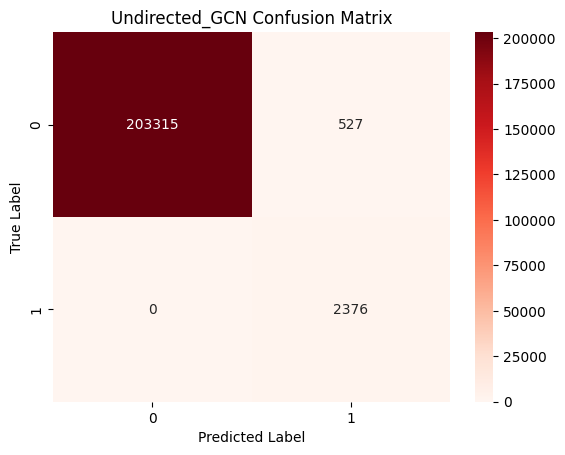



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Undirected_GCN
              precision    recall  f1-score   support

           0     1.0000    0.9974    0.9987    199522
           1     0.8123    1.0000    0.8964      2280

    accuracy                         0.9974    201802
   macro avg     0.9061    0.9987    0.9475    201802
weighted avg     0.9979    0.9974    0.9975    201802



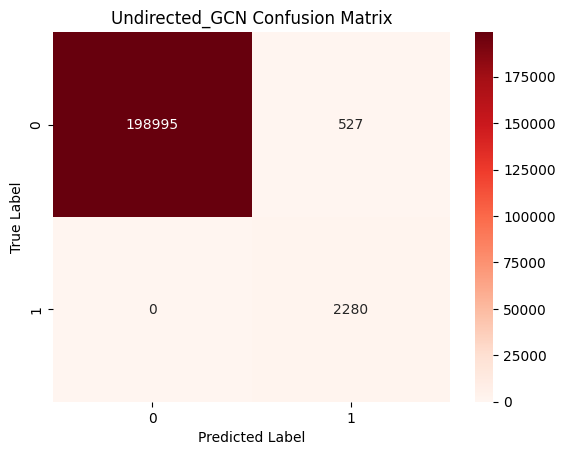



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Undirected_GCN
              precision    recall  f1-score   support

           0     1.0000    0.9975    0.9987    208567
           1     0.8248    1.0000    0.9040      2481

    accuracy                         0.9975    211048
   macro avg     0.9124    0.9987    0.9514    211048
weighted avg     0.9979    0.9975    0.9976    211048



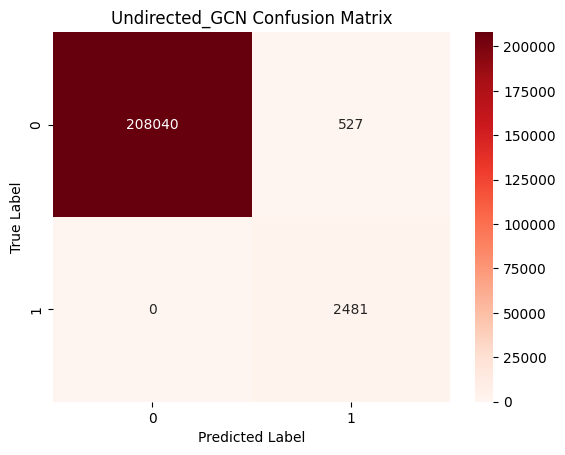



Begin spatial training Directed_GCN. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.36521, Macro recall: 0.57979, Total accuracy: 0.98956, Macro F1-score: 0.62812. Loss backpropagated 2146 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.33275, Macro recall: 0.88926, Total accuracy: 0.99530, Macro F1-score: 0.89526. Loss backpropagated 969 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.33037, Macro recall: 0.92656, Total accuracy: 0.99626, Macro F1-score: 0.91932. Loss backpropagated 771 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 4, Total weighted loss: 0.32984, Macro recall: 0.93699, Total accuracy: 0.99673, Macro F1-score: 0.92949. Loss backpropagated 674 times.
Total number 

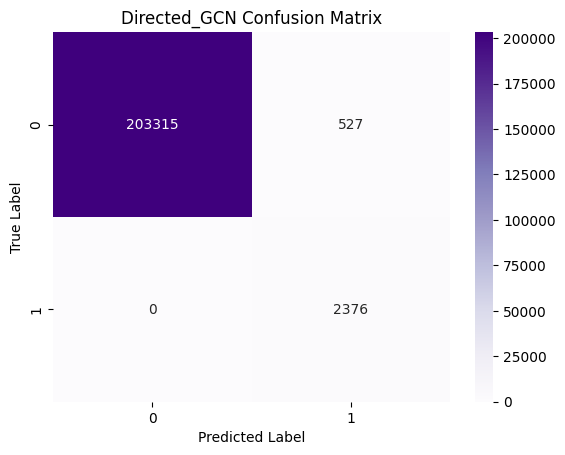



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Directed_GCN
              precision    recall  f1-score   support

           0     1.0000    0.9974    0.9987    199522
           1     0.8123    1.0000    0.8964      2280

    accuracy                         0.9974    201802
   macro avg     0.9061    0.9987    0.9475    201802
weighted avg     0.9979    0.9974    0.9975    201802



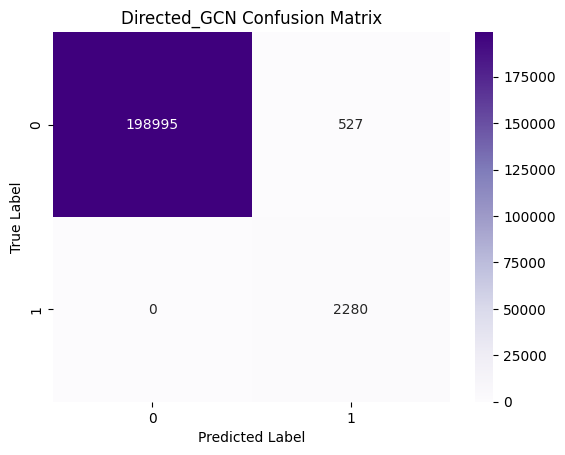



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Directed_GCN
              precision    recall  f1-score   support

           0     1.0000    0.9975    0.9987    208567
           1     0.8248    1.0000    0.9040      2481

    accuracy                         0.9975    211048
   macro avg     0.9124    0.9987    0.9514    211048
weighted avg     0.9979    0.9975    0.9976    211048



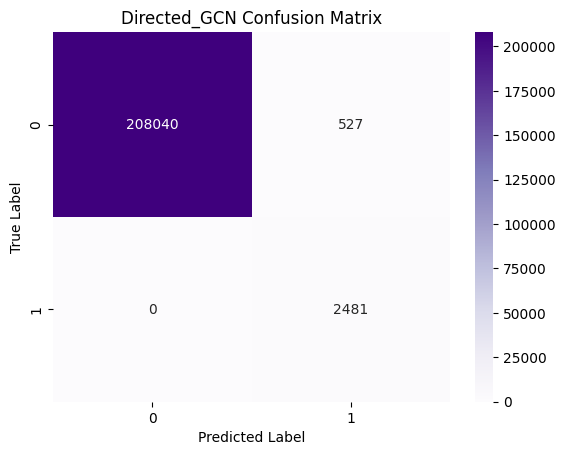

spatial GCN took 7.216957505544027 minutes!
model GraphSAGE


Begin spatial training Undirected_GraphSAGE. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.35858, Macro recall: 0.66012, Total accuracy: 0.99049, Macro F1-score: 0.71667. Loss backpropagated 1951 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.33115, Macro recall: 0.91514, Total accuracy: 0.99588, Macro F1-score: 0.91061. Loss backpropagated 847 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.32940, Macro recall: 0.93362, Total accuracy: 0.99665, Macro F1-score: 0.92749. Loss backpropagated 689 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 4, Total weighted loss: 0.32876, Macro recall: 0.94122, Total accuracy: 0.99686, M

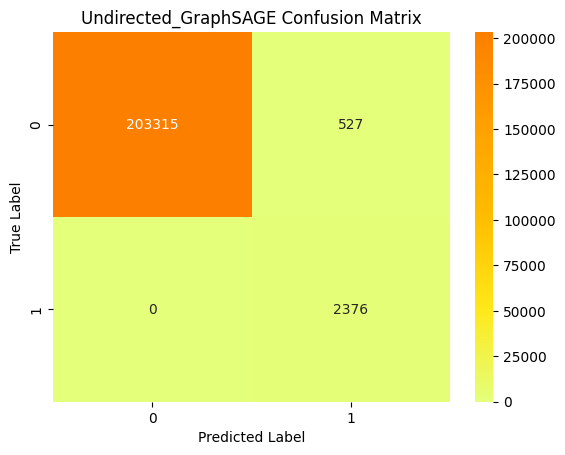



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Undirected_GraphSAGE
              precision    recall  f1-score   support

           0     1.0000    0.9974    0.9987    199522
           1     0.8123    1.0000    0.8964      2280

    accuracy                         0.9974    201802
   macro avg     0.9061    0.9987    0.9475    201802
weighted avg     0.9979    0.9974    0.9975    201802



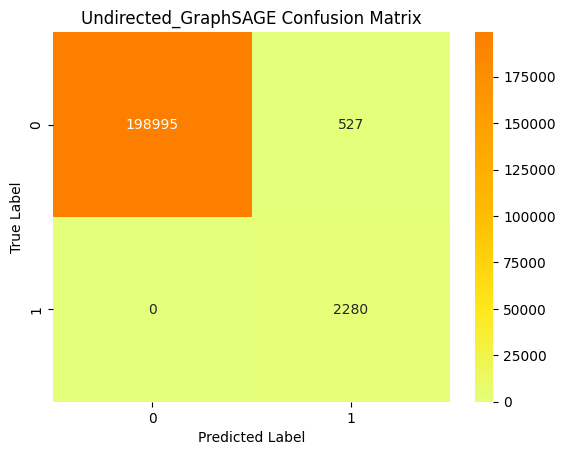



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Undirected_GraphSAGE
              precision    recall  f1-score   support

           0     1.0000    0.9975    0.9987    208567
           1     0.8248    1.0000    0.9040      2481

    accuracy                         0.9975    211048
   macro avg     0.9124    0.9987    0.9514    211048
weighted avg     0.9979    0.9975    0.9976    211048



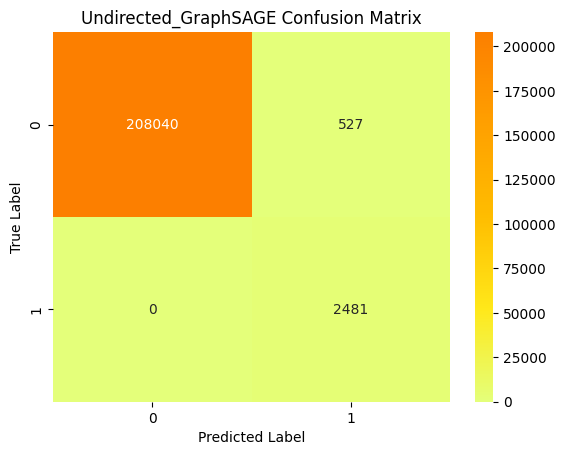



Begin spatial training Directed_GraphSAGE. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.34834, Macro recall: 0.82635, Total accuracy: 0.99429, Macro F1-score: 0.86120. Loss backpropagated 1177 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.33038, Macro recall: 0.96226, Total accuracy: 0.99775, Macro F1-score: 0.95173. Loss backpropagated 462 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.32890, Macro recall: 0.97566, Total accuracy: 0.99834, Macro F1-score: 0.96445. Loss backpropagated 341 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 4, Total weighted loss: 0.32825, Macro recall: 0.97953, Total accuracy: 0.99859, Macro F1-score: 0.96976. Loss backpropagated 290 times.
Total n

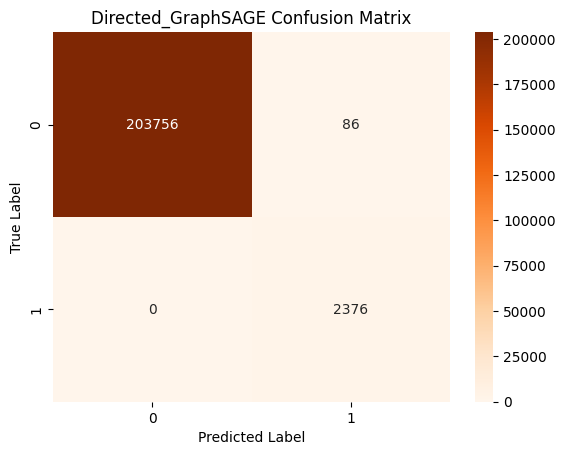



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Directed_GraphSAGE
              precision    recall  f1-score   support

           0     1.0000    0.9996    0.9998    199522
           1     0.9637    1.0000    0.9815      2280

    accuracy                         0.9996    201802
   macro avg     0.9818    0.9998    0.9906    201802
weighted avg     0.9996    0.9996    0.9996    201802



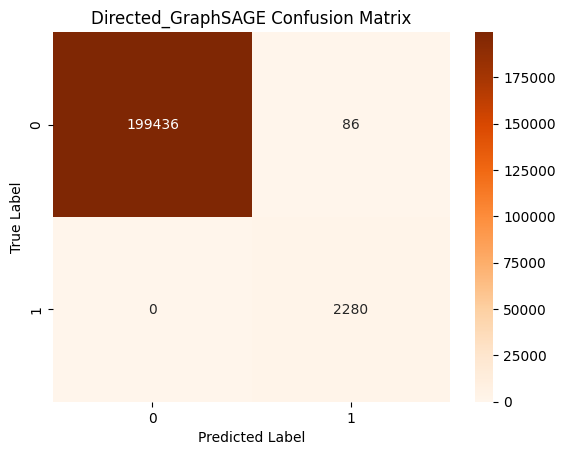



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Directed_GraphSAGE
              precision    recall  f1-score   support

           0     1.0000    0.9996    0.9998    208567
           1     0.9665    1.0000    0.9830      2481

    accuracy                         0.9996    211048
   macro avg     0.9832    0.9998    0.9914    211048
weighted avg     0.9996    0.9996    0.9996    211048



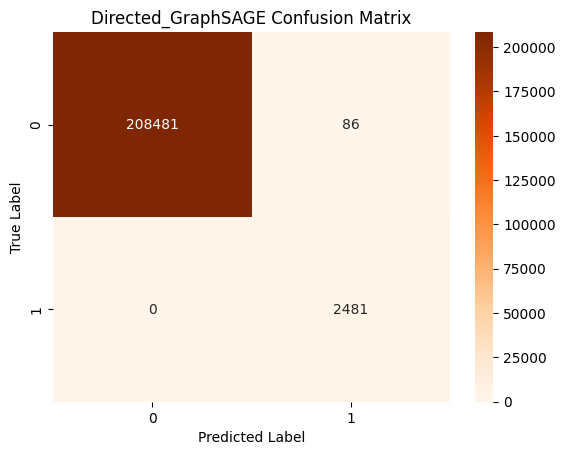

spatial GraphSAGE took 5.774670394261678 minutes!
model GAT


Begin spatial training Undirected_GAT. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.34833, Macro recall: 0.88994, Total accuracy: 0.99541, Macro F1-score: 0.89729. Loss backpropagated 946 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.33230, Macro recall: 0.95625, Total accuracy: 0.99697, Macro F1-score: 0.93646. Loss backpropagated 624 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.33067, Macro recall: 0.95703, Total accuracy: 0.99688, Macro F1-score: 0.93478. Loss backpropagated 644 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 4, Total weighted loss: 0.32968, Macro recall: 0.96219, Total accuracy: 0.99721, Macro F1

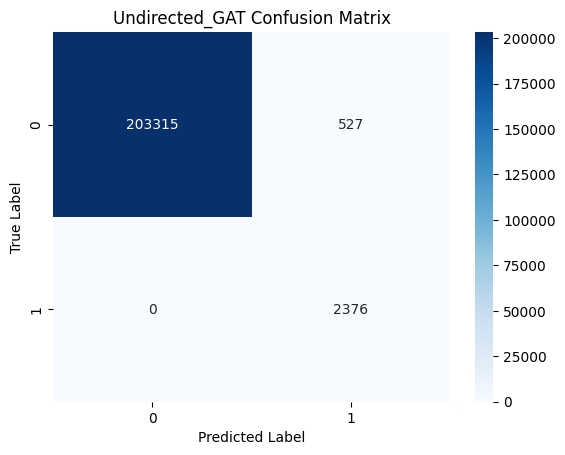



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Undirected_GAT
              precision    recall  f1-score   support

           0     1.0000    0.9974    0.9987    199522
           1     0.8123    1.0000    0.8964      2280

    accuracy                         0.9974    201802
   macro avg     0.9061    0.9987    0.9475    201802
weighted avg     0.9979    0.9974    0.9975    201802



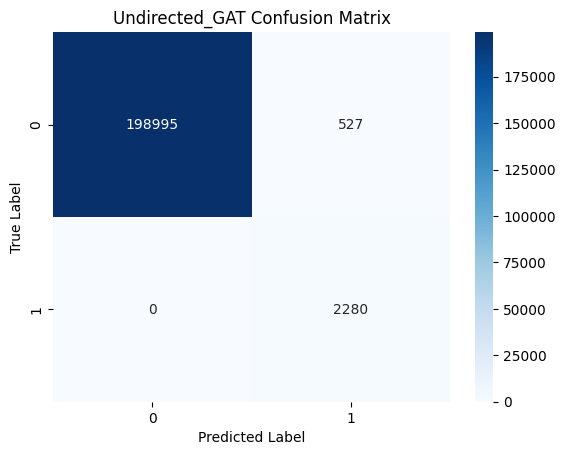



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Undirected_GAT
              precision    recall  f1-score   support

           0     1.0000    0.9975    0.9987    208567
           1     0.8248    1.0000    0.9040      2481

    accuracy                         0.9975    211048
   macro avg     0.9124    0.9987    0.9514    211048
weighted avg     0.9979    0.9975    0.9976    211048



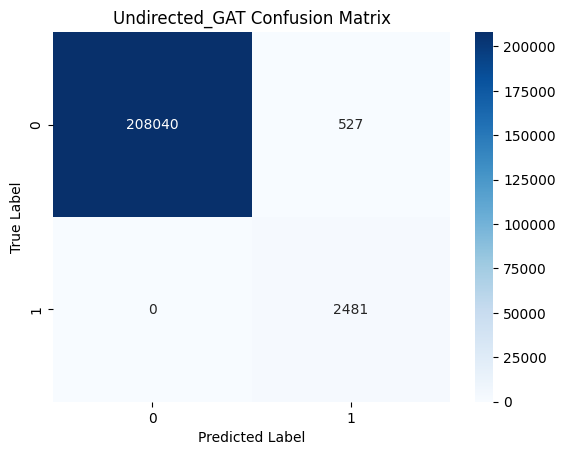



Begin spatial training Directed_GAT. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.35058, Macro recall: 0.88647, Total accuracy: 0.99471, Macro F1-score: 0.88447. Loss backpropagated 966 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.33322, Macro recall: 0.96313, Total accuracy: 0.99702, Macro F1-score: 0.93808. Loss backpropagated 615 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.33227, Macro recall: 0.96158, Total accuracy: 0.99683, Macro F1-score: 0.93447. Loss backpropagated 654 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 4, Total weighted loss: 0.33180, Macro recall: 0.96071, Total accuracy: 0.99674, Macro F1-score: 0.93280. Loss backpropagated 672 times.
Total number o

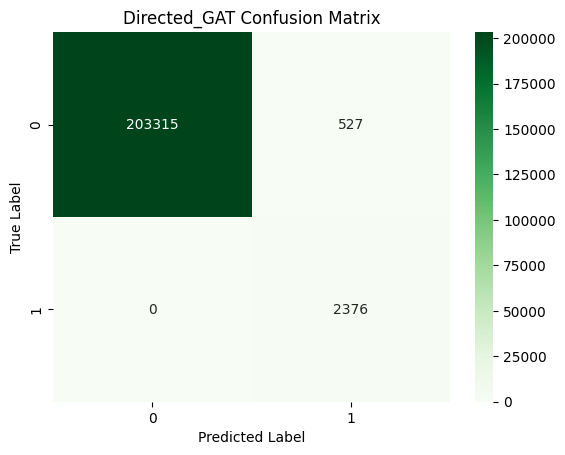



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Directed_GAT
              precision    recall  f1-score   support

           0     1.0000    0.9974    0.9987    199522
           1     0.8123    1.0000    0.8964      2280

    accuracy                         0.9974    201802
   macro avg     0.9061    0.9987    0.9475    201802
weighted avg     0.9979    0.9974    0.9975    201802



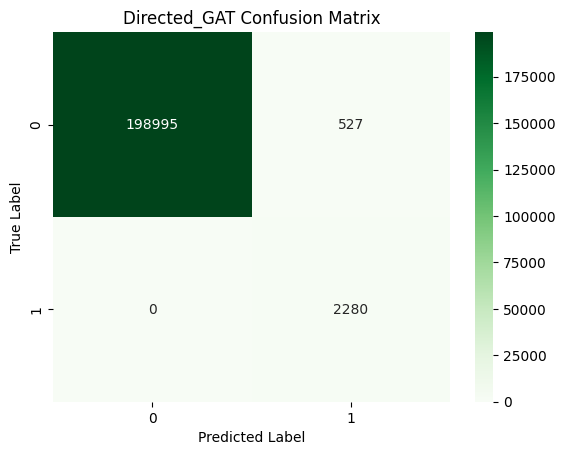



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Directed_GAT
              precision    recall  f1-score   support

           0     1.0000    0.9975    0.9987    208567
           1     0.8248    1.0000    0.9040      2481

    accuracy                         0.9975    211048
   macro avg     0.9124    0.9987    0.9514    211048
weighted avg     0.9979    0.9975    0.9976    211048



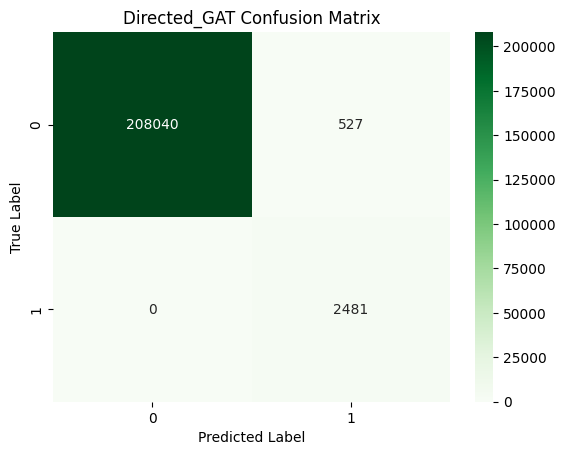

spatial GAT took 10.80777911345164 minutes!
model_type spatiotemporal
train_loader <class 'torch_geometric.deprecation.DataLoader'>
model GRUGCN


Begin spatiotemporal training Undirected_GRUGCN. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.52238, Macro recall: 0.49977, Total accuracy: 0.98802, Macro F1-score: 0.49699. Loss backpropagated 2382 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.35399, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.35382, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 23

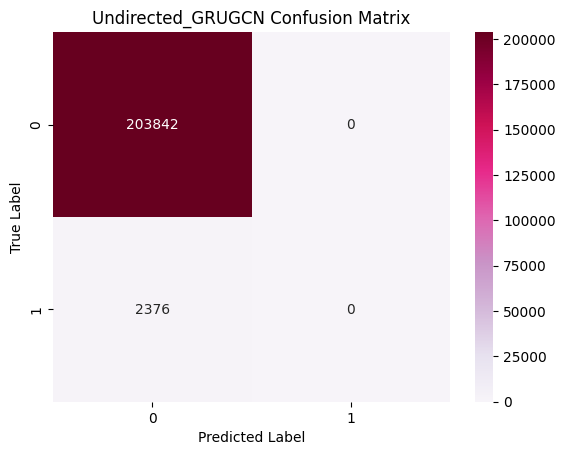



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Undirected_GRUGCN
              precision    recall  f1-score   support

           0     0.9887    1.0000    0.9943    199522
           1     0.0000    0.0000    0.0000      2280

    accuracy                         0.9887    201802
   macro avg     0.4944    0.5000    0.4972    201802
weighted avg     0.9775    0.9887    0.9831    201802



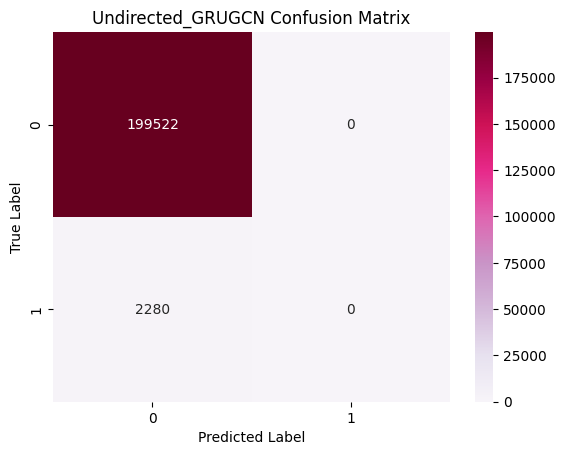



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Undirected_GRUGCN
              precision    recall  f1-score   support

           0     0.9882    1.0000    0.9941    208567
           1     0.0000    0.0000    0.0000      2481

    accuracy                         0.9882    211048
   macro avg     0.4941    0.5000    0.4970    211048
weighted avg     0.9766    0.9882    0.9824    211048



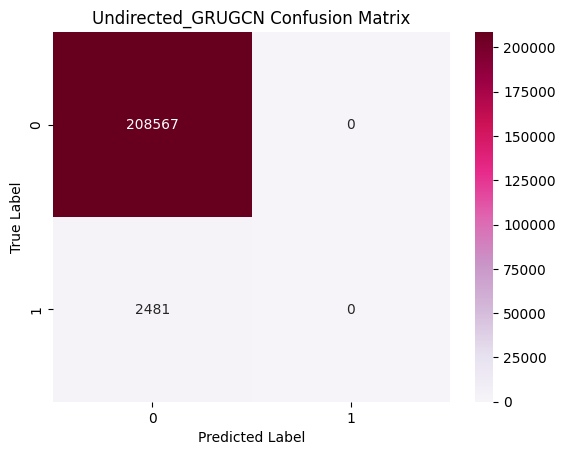



Begin spatiotemporal training Directed_GRUGCN. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.52221, Macro recall: 0.49988, Total accuracy: 0.98824, Macro F1-score: 0.49704. Loss backpropagated 2381 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.35401, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.35380, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 4, Total weighted loss: 0.35379, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.


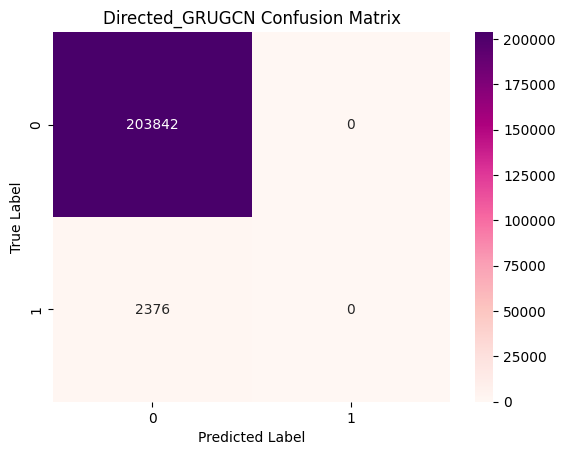



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Directed_GRUGCN
              precision    recall  f1-score   support

           0     0.9887    1.0000    0.9943    199522
           1     0.0000    0.0000    0.0000      2280

    accuracy                         0.9887    201802
   macro avg     0.4944    0.5000    0.4972    201802
weighted avg     0.9775    0.9887    0.9831    201802



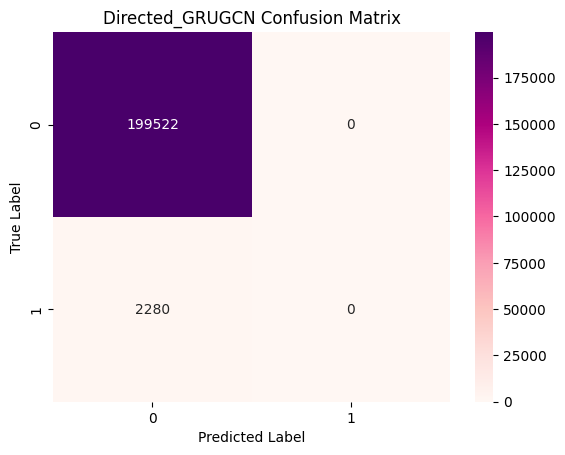



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Directed_GRUGCN
              precision    recall  f1-score   support

           0     0.9882    1.0000    0.9941    208567
           1     0.0000    0.0000    0.0000      2481

    accuracy                         0.9882    211048
   macro avg     0.4941    0.5000    0.4970    211048
weighted avg     0.9766    0.9882    0.9824    211048



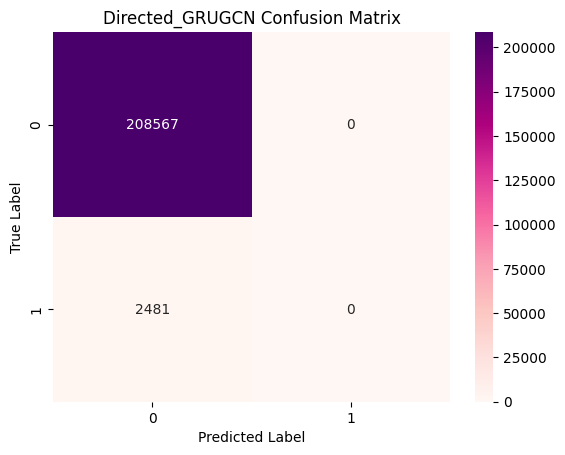

spatiotemporal GRUGCN took 7.791213941574097 minutes!
model GRUSAGE


Begin spatiotemporal training Undirected_GRUSAGE. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.52157, Macro recall: 0.49977, Total accuracy: 0.98803, Macro F1-score: 0.49699. Loss backpropagated 2381 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.35405, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.35388, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 4, Total weighted loss: 0.35386, Macro recall: 0.50000, Total accur

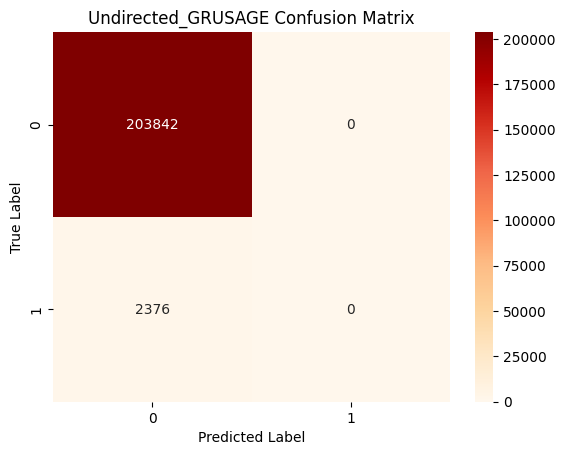



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Undirected_GRUSAGE
              precision    recall  f1-score   support

           0     0.9887    1.0000    0.9943    199522
           1     0.0000    0.0000    0.0000      2280

    accuracy                         0.9887    201802
   macro avg     0.4944    0.5000    0.4972    201802
weighted avg     0.9775    0.9887    0.9831    201802



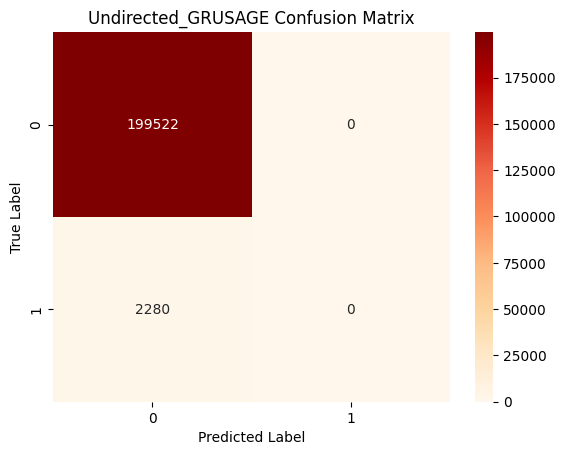



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Undirected_GRUSAGE
              precision    recall  f1-score   support

           0     0.9882    1.0000    0.9941    208567
           1     0.0000    0.0000    0.0000      2481

    accuracy                         0.9882    211048
   macro avg     0.4941    0.5000    0.4970    211048
weighted avg     0.9766    0.9882    0.9824    211048



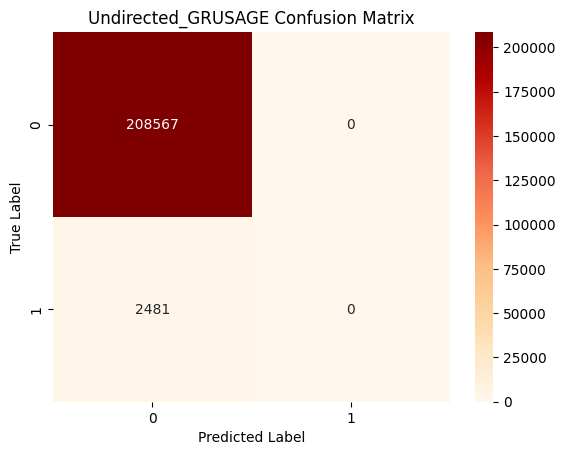



Begin spatiotemporal training Directed_GRUSAGE. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.51416, Macro recall: 0.65737, Total accuracy: 0.98834, Macro F1-score: 0.69022. Loss backpropagated 1637 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.33036, Macro recall: 0.99262, Total accuracy: 0.99980, Macro F1-score: 0.99550. Loss backpropagated 42 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.33189, Macro recall: 0.99577, Total accuracy: 0.99986, Macro F1-score: 0.99691. Loss backpropagated 29 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 4, Total weighted loss: 0.33068, Macro recall: 0.99577, Total accuracy: 0.99985, Macro F1-score: 0.99680. Loss backpropagated 30 times.
Total

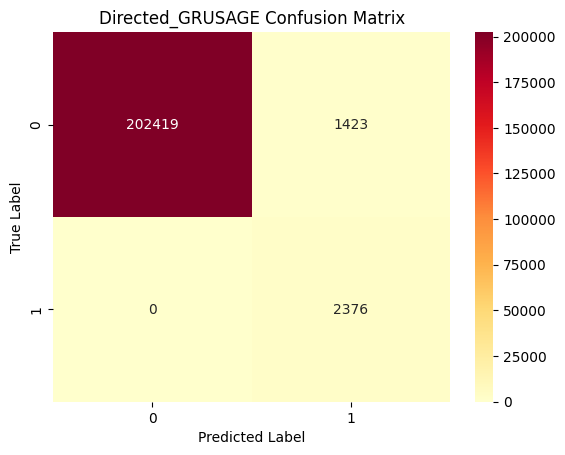



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Directed_GRUSAGE
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964    199522
           1     0.6157    1.0000    0.7622      2280

    accuracy                         0.9929    201802
   macro avg     0.8079    0.9964    0.8793    201802
weighted avg     0.9957    0.9929    0.9938    201802



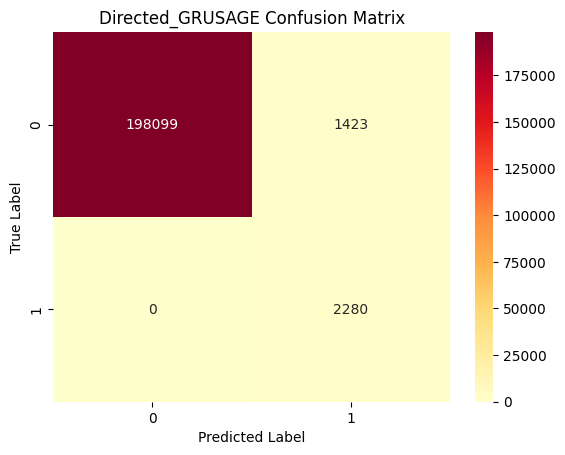



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Directed_GRUSAGE
              precision    recall  f1-score   support

           0     1.0000    0.9932    0.9966    208567
           1     0.6355    1.0000    0.7771      2481

    accuracy                         0.9933    211048
   macro avg     0.8178    0.9966    0.8869    211048
weighted avg     0.9957    0.9933    0.9940    211048



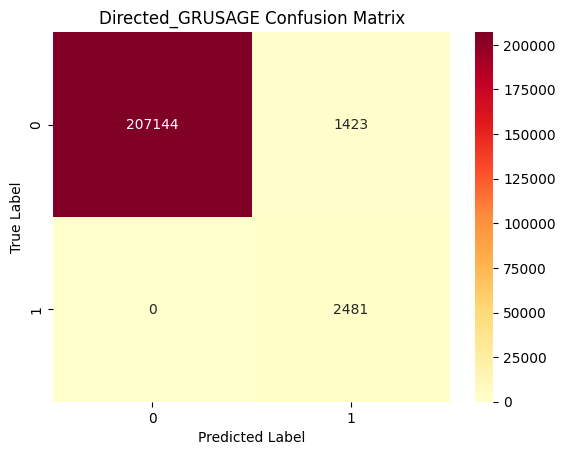

spatiotemporal GRUSAGE took 5.6335022211074826 minutes!
model GRUGAT


Begin spatiotemporal training Undirected_GRUGAT. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.51739, Macro recall: 0.49972, Total accuracy: 0.98792, Macro F1-score: 0.49696. Loss backpropagated 2380 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.35395, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.35379, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 4, Total weighted loss: 0.35378, Macro recall: 0.50000, Total accur

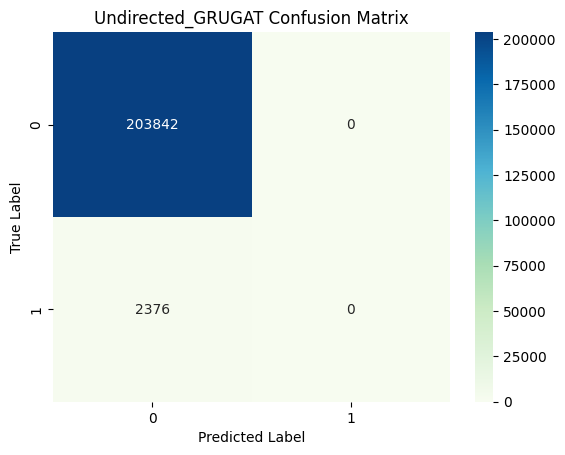



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Undirected_GRUGAT
              precision    recall  f1-score   support

           0     0.9887    1.0000    0.9943    199522
           1     0.0000    0.0000    0.0000      2280

    accuracy                         0.9887    201802
   macro avg     0.4944    0.5000    0.4972    201802
weighted avg     0.9775    0.9887    0.9831    201802



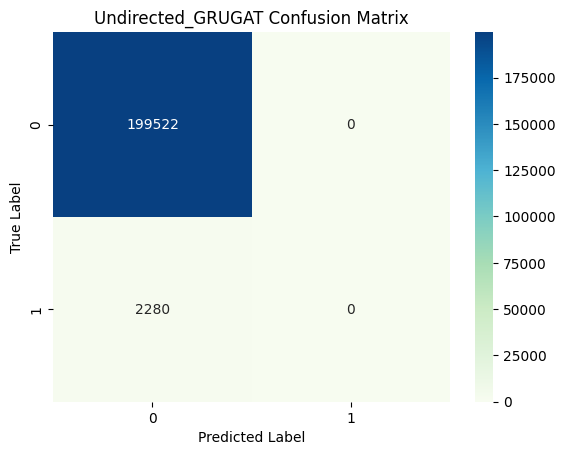



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Undirected_GRUGAT
              precision    recall  f1-score   support

           0     0.9882    1.0000    0.9941    208567
           1     0.0000    0.0000    0.0000      2481

    accuracy                         0.9882    211048
   macro avg     0.4941    0.5000    0.4970    211048
weighted avg     0.9766    0.9882    0.9824    211048



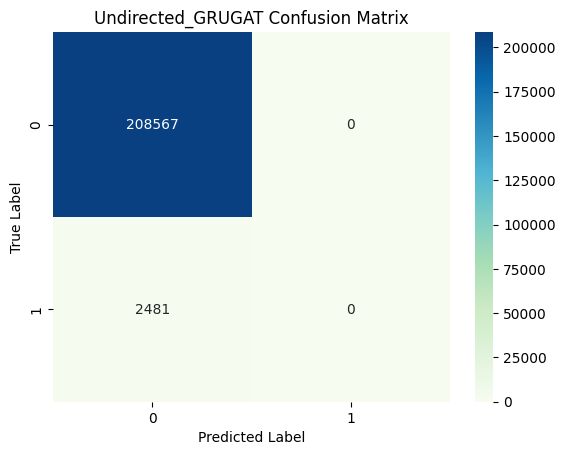



Begin spatiotemporal training Directed_GRUGAT. Training data list on a single error type.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 1, Total weighted loss: 0.50598, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 2, Total weighted loss: 0.35393, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 3, Total weighted loss: 0.35378, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.
Total number of graphs: 4483, Presence of class 0: 4483, Presence of class 1: 2376
Epoch 4, Total weighted loss: 0.35378, Macro recall: 0.50000, Total accuracy: 0.98848, Macro F1-score: 0.49710. Loss backpropagated 2376 times.


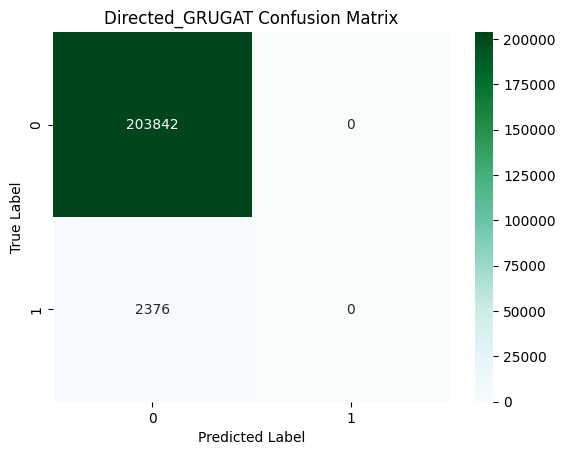



Test 2: How does the model perform on unseen data, of the same error type?.
Model: Directed_GRUGAT
              precision    recall  f1-score   support

           0     0.9887    1.0000    0.9943    199522
           1     0.0000    0.0000    0.0000      2280

    accuracy                         0.9887    201802
   macro avg     0.4944    0.5000    0.4972    201802
weighted avg     0.9775    0.9887    0.9831    201802



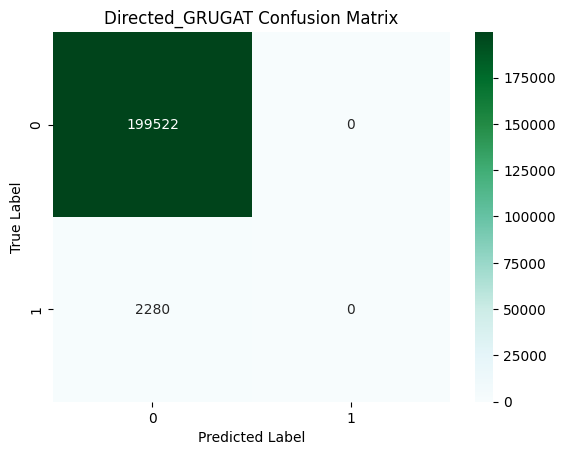



Test 3: How does the model perform on unseen data, of a different error type?.
Model: Directed_GRUGAT
              precision    recall  f1-score   support

           0     0.9882    1.0000    0.9941    208567
           1     0.0000    0.0000    0.0000      2481

    accuracy                         0.9882    211048
   macro avg     0.4941    0.5000    0.4970    211048
weighted avg     0.9766    0.9882    0.9824    211048



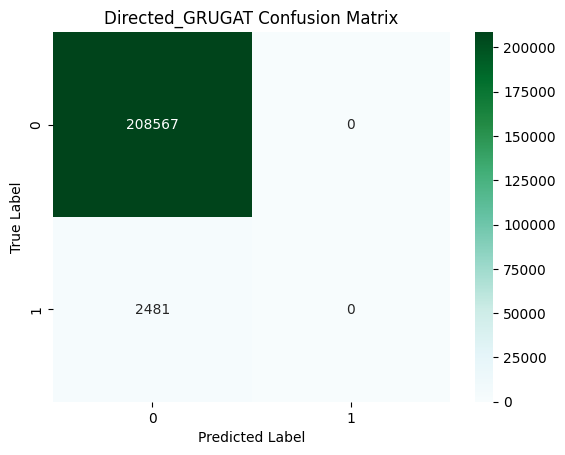

spatiotemporal GRUGAT took 11.533744736512501 minutes!


In [44]:
def train_and_evaluate_model_type(name, model_type, settings, train_case, train_loader, test1, test_loader1, test2, test_loader2, optimizer_params):
  """
  Trains and evaluates a model of a specified type with given settings and data loaders.

  Parameters
  ----------
  name : str
      The name of the model, such as 'GCN', 'GraphSAGE', or 'GAT'.
  model_type : str
      The type of the model, either 'spatial' or 'spatiotemporal'.
  settings : list
      A list of supported model settings, e.g., ['Undirected', 'Directed'].
  train_case : str
      Description of the training case.
  train_loader : DataLoader
      DataLoader for the training data.
  test1 : str
      Description of the first test case.
  test_loader1 : DataLoader
      DataLoader for the first set of test data.
  test2 : str
      Description of the second test case.
  test_loader2 : DataLoader
      DataLoader for the second set of test data.
  optimizer_params : dict
      Parameters for the optimizer, such as learning rate and weight decay.
  """
  for setting in settings:
    model_name = f'{setting}_{name}'

    assert model_type in MODELS, f'Error: {model_type} not found in MODELS.'
    assert model_name in MODELS[model_type], f'Error: {model_name} not found in MODELS[{model_type}].'

    model = MODELS[model_type][model_name]

    print('\n====================\n')
    print(f'Begin {model_type} training {model_name}. {train_case}.')

    if USE_WANDB:
      wandb.init(
          project="cs224w-final-project",
          config={"model_name": model_name},
          name=datetime.now().strftime("%m-%d %H:%M:%S ") + model_name
      )
      wandb.run.log_code(include_fn=lambda path: path.endswith(".ipynb"))

    if model_type == 'spatial':
      model = spatial_train(model, train_loader, class_weights=True, num_epoch=20, verbose=True)
    else:
      model = spatiotemporal_train(model, train_loader, class_weights=True, num_epoch=20, verbose=True)

    print('\n====================\n')
    print(f'Test 1: Evaluate {model_type} {model_name} on the training dataset.')

    if model_type == 'spatial':
      spatial_evaluate(model, model_name, train_loader)
    else:
      spatiotemporal_evaluate(model, model_name, train_loader)

    print('\n====================\n')
    print(f'Test 2: {test1}.')

    if model_type == 'spatial':
      spatial_evaluate(model, model_name, test_loader1)
    else:
      spatiotemporal_evaluate(model, model_name, test_loader1)

    print('\n====================\n')
    print(f'Test 3: {test2}.')

    if model_type == 'spatial':
      spatial_evaluate(model, model_name, test_loader2)
    else:
      spatiotemporal_evaluate(model, model_name, test_loader2)

    if USE_WANDB:
      wandb.finish()

    optimizer = torch.optim.Adam(model.parameters(), **optimizer_params)
    save_model(model, '', model_name, optimizer)

# Define models and their types
models = {
    'spatial': ['GCN', 'GraphSAGE', 'GAT'],
    'spatiotemporal': ['GRUGCN', 'GRUSAGE', 'GRUGAT']
}

# Train and evaluate each model type
for model_type in models.keys(): # spatial, spatiotemporal
  print("model_type", model_type)
  train_loader = data_loaders[model_type + '_loader_train_case']
  test_loader1 = data_loaders[model_type + '_loader_test1']
  test_loader2 = data_loaders[model_type + '_loader_test2']
  print("train_loader", train_loader.__class__)

  for model in models[model_type]: # ['GCN', 'GraphSAGE', 'GAT'], ['GRUGCN', 'GRUSAGE', 'GRUGAT']
      print("model", model)
      start = time.time()
      train_and_evaluate_model_type(model, model_type, ['Undirected', 'Directed'],
                                    TRAIN_TEST_CASES['train_case'], train_loader,
                                    TRAIN_TEST_CASES['test1'], test_loader1,
                                    TRAIN_TEST_CASES['test2'], test_loader2,
                                     {'lr': 0.001, 'weight_decay': 5e-4})
      end = time.time()
      print(f"{model_type} {model} took {(end - start)/60} minutes!")